In [ ]:
import pandas as pd

FEATURE_STORE_PATH = '../data/feature_store.parquet'
df = pd.read_parquet(FEATURE_STORE_PATH)
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# --- Temporal Train/Test Split ---
split_date = df['TX_DATETIME'].min() + pd.Timedelta(days=21)

train_df = df[df['TX_DATETIME'] < split_date]
test_df = df[df['TX_DATETIME'] >= split_date]

print(f"Data split on: {split_date}")
print(f"Training set size: {len(train_df)} ({len(train_df) / len(df):.2%})")
print(f"Test set size: {len(test_df)} ({len(test_df) / len(df):.2%})")
print(f"Fraud cases in Training set: {train_df['TX_FRAUD'].sum()}")
print(f"Fraud cases in Test set: {test_df['TX_FRAUD'].sum()}")

Data split on: 2018-04-22 00:00:31
Training set size: 201256 (69.87%)
Test set size: 86806 (30.13%)
Fraud cases in Training set: 934
Fraud cases in Test set: 768


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.06      0.11     86038
           1       0.01      0.99      0.02       768

    accuracy                           0.06     86806
   macro avg       0.50      0.52      0.06     86806
weighted avg       0.99      0.06      0.11     86806


--- Confusion Matrix ---


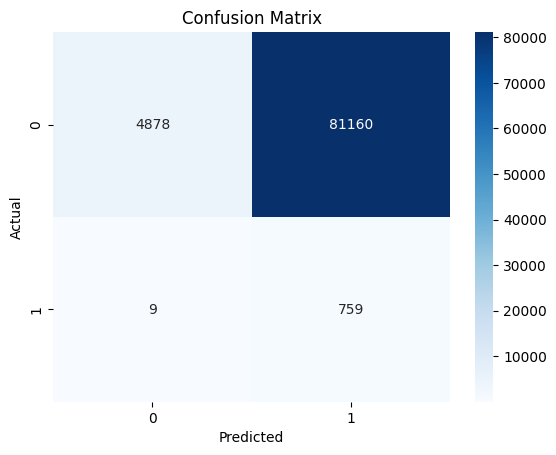

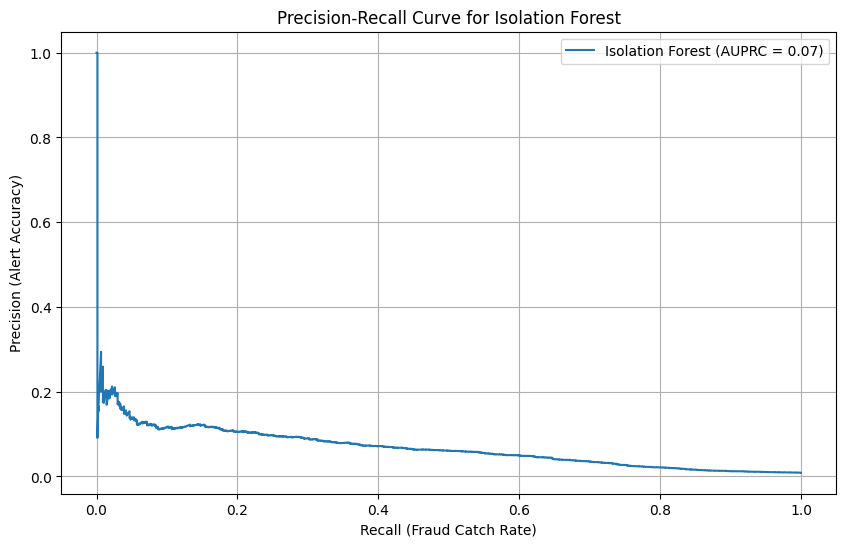

In [ ]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load the saved model ---
MODEL_PATH = '../models/isolation_forest_v1.joblib'
model = joblib.load(MODEL_PATH)

# These must be the same features the model was trained on
features = [
    'TX_AMOUNT', 'TX_DURING_WEEKEND', 'HourOfDay',
    'CUSTOMER_ID_NB_TX_1H', 'CUSTOMER_ID_NB_TX_24H', 'CUSTOMER_ID_NB_TX_7D',
    'CUSTOMER_ID_AMOUNT_ZSCORE_30D', 'CUSTOMER_ID_TIME_SINCE_LAST_TX',
    'TERMINAL_ID_RISK_30D', 'CUSTOMER_ID_TERMINAL_ID_NB_TX_30D'
]
target = 'TX_FRAUD'

# --- Make predictions on the test set ---
X_test = test_df[features]
y_test = test_df[target]

# Isolation Forest predicts -1 for anomalies (fraud) and 1 for normal
# We need to map this to our 1 (fraud) and 0 (legit) format
predictions = model.predict(X_test)
# Map: -1 -> 1 (Fraud), 1 -> 0 (Legit)
y_pred = [1 if p == -1 else 0 for p in predictions]

# --- Evaluate Performance ---
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# --- Precision-Recall Curve ---
y_scores_iforest = -model.decision_function(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_iforest)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'Isolation Forest (AUPRC = {pr_auc:.2f})')
plt.xlabel('Recall (Fraud Catch Rate)')
plt.ylabel('Precision (Alert Accuracy)')
plt.title('Precision-Recall Curve for Isolation Forest')
plt.legend(loc='best')
plt.grid(True)
plt.show()

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86038
           1       0.59      0.50      0.54       768

    accuracy                           0.99     86806
   macro avg       0.79      0.75      0.77     86806
weighted avg       0.99      0.99      0.99     86806


--- XGBoost Confusion Matrix ---


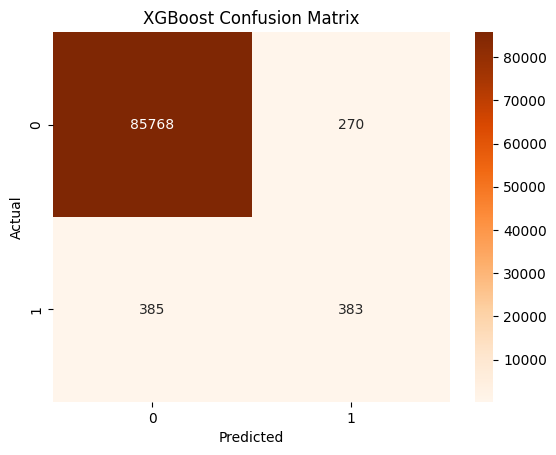

Corrected Threshold for >=85% recall: 0.0005
Precision at this threshold: 0.0123


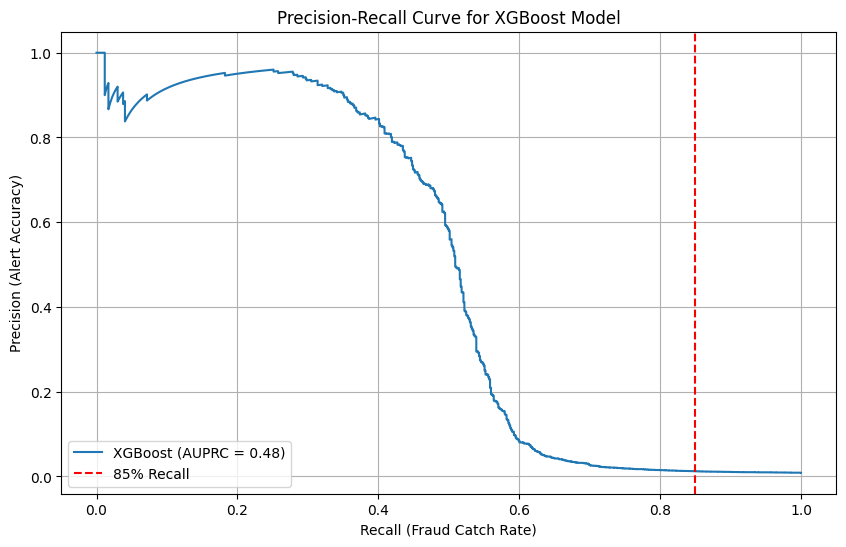

In [ ]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load the saved XGBoost model ---
XGB_MODEL_PATH = '../models/xgboost_v1.joblib'
xgb_model = joblib.load(XGB_MODEL_PATH)

# --- Make predictions on the test set ---
y_pred_xgb = xgb_model.predict(X_test)

# To plot the PR curve, we need the probability scores for the positive class (fraud)
y_scores_xgb = xgb_model.predict_proba(X_test)[:, 1]

# --- Evaluate Performance ---
print("--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

print("\n--- XGBoost Confusion Matrix ---")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# --- Precision-Recall Curve ---
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_xgb)
pr_auc = auc(recall, precision)

# --- Find threshold for at least 85% recall ---
target_recall = 0.85
# Find all indices where recall is >= our target

import numpy as np 
idx = np.where(recall >= target_recall)[0]

if len(idx) > 0:
    # Use the LAST index, which corresponds to the highest precision for that recall level
    best_idx = idx[-1]
    threshold_85_recall = thresholds[best_idx]
    
    print(f"Corrected Threshold for >=85% recall: {threshold_85_recall:.4f}")
    print(f"Precision at this threshold: {precision[best_idx]:.4f}")
else:
    print("No threshold achieves 85% recall.")

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'XGBoost (AUPRC = {pr_auc:.2f})')
plt.axvline(target_recall, color='red', linestyle='--', label='85% Recall')
plt.xlabel('Recall (Fraud Catch Rate)')
plt.ylabel('Precision (Alert Accuracy)')
plt.title('Precision-Recall Curve for XGBoost Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()
